In [ ]:
# %matplotlib widget
# 3D Pathfinding Example with your updated files
#import python_motion_planning as pmp
import numpy as np
import matplotlib.pyplot as plt
import random
from fontTools.misc.py23 import xrange

from utils.environment.env import Grid, Env
from global_planner.graph_search.a_star import AStar
# from global_planner.graph_search.dijkstra import Dijkstra
# from global_planner.graph_search.jps import JPS
# from global_planner.graph_search.lazy_theta_star import LazyThetaStar
# from global_planner.graph_search.gbfs import GBFS
# from src.Pathfinding3D.utils.plot.plot import Plot
# from src.Pathfinding3D.utils.agent.agent import Robot
# from src.Pathfinding3D.environment3D.node import Node
# from src.Pathfinding3D.utils.planner.planner import Planner

# Create environment with custom obstacles
# env = Grid(25, 20, 12)
env = Grid(9, 9, 14)
obstacles = set()

#because it doesn't appear to work during the initialization of the env, or is somehow removed. Either way the shit is busted.
def add_walls(obstacles, env, z0=0, z1=None, thickness=1):
    x, y, z = env.x_range, env.y_range, env.z_range
    for i in range(x):
        for j in range(y):
            obstacles.add((i, j, 0))  # Floor
            obstacles.add((i, j, z - 1))  # Ceiling

        # XZ faces
    for i in range(x):
        for k in range(z):
            obstacles.add((i, 0, k))  # Front wall
            obstacles.add((i, y - 1, k))  # Back wall

    # YZ faces
    for j in range(y):
        for k in range(z):
            obstacles.add((0, j, k))  # Left wall
            obstacles.add((x - 1, j, k))  # Right wall


def add_corner_wall(obstacles, env, z0=0, z1=None, thickness=1):
    """
    Corner wall boundary runs the full length of both sides.
    - corner: (x0, y0) where the two walls meet (e.g., (0,0) for lower-left corner)
    - thickness: how many voxels thick to make each wall (prevents diagonal slips)
    """
    nx, ny, nz = env.x_range, env.y_range, env.z_range # get grid size (x, y, z)

    # if no explicit top height given, use the top layer (last valid z index)
    if z1 is None:
        z1 = nz - 1  # default to last z-index

    x0, y0 = 0, 0  # corner where the two walls meet

    # min(y0 + thickness, ny) clips the stripe so we never exceed the grid height ny
    for x in range(x0, nx):  # span full X: 0..nx-1
        for y in range(y0, min(y0 + thickness, ny)):  # to build a wall Y near y0
            for z in range(z0, z1 + 1):  # # vertical extent from z0 to z1
                obstacles.add((x, y, z))


def add_floor(obstacles, env, z0=0, thickness=1):
    """
    Add a horizontal obstacle floor spanning the full X and Y dimensions.
    - z0: starting height of the floor
    - thickness: how many layers thick the floor should be
    """
    nx, ny, nz = env.x_range, env.y_range, env.z_range

    # floor spans all x and y, but only thickness layers in z
    for x in range(nx+1):
        for y in range(ny+1):
            for z in range(z0, min(z0 + thickness, nz)):
                obstacles.add((x, y, z))

def add_multi_floors(obstacles, env, holes= None,  z0=0, thickness=1):
    """
    Add a horizontal obstacle floor spanning the full X and Y dimensions.
    - z0: starting height of the floor
    - thickness: how many layers thick the floor should be
    """
    nx, ny, nz = env.x_range, env.y_range, env.z_range

    # floor spans all x and y, but only thickness layers in z
    for x in range(nx+1):
        for y in range(ny+1):
            for z in range(z0, min(z0 + thickness, nz)):
                obstacles.add((x, y, z))

    # remove a block to create a hole in the floor
    if holes:
        for hole in holes:
            if hole in obstacles:
                obstacles.remove(hole)
    # obstacles.remove((x, y, z))
                    
# Build corner wall
add_walls(obstacles, env, z0=0, z1=env.z_range + 1, thickness=1)
add_corner_wall(obstacles, env, z0=0, z1=env.z_range - 1, thickness=1)
add_floor(obstacles, env, z0=0, thickness=1)
env.update(obstacles)


# First Floor design    
# first_floor_block_coords



# adding random buildings obstacles
random.seed(5)
def generate_random_obstacles(obstacle_amount=20, x_max=25, y_max=20, z_max=12):
    for _ in range(obstacle_amount):
        x = random.randrange(x_max)
        y = random.randrange(y_max)
        height = random.randrange(5, z_max)
        for z in range(height):
            obstacles.add((x, y, z))

def generate_obstacle_gridlike(obstacle_amount=20, x_max=25, y_max=20, z_max=12):
    for x in range(0, 25, 7):
        for y in range(0, 20, 4):
            for z in range(10):
                for i in range(4):
                    for j in range(3):
                        obstacles.add((x + i, y + j, z))

def generate_floor_obstacles(obstacle_coords, floor_height):
    for coords in obstacle_coords:
        x, y = coords[0], coords[1]
        # x = random.randrange(x_max)
        # y = random.randrange(y_max)
        # height = random.randrange(5, z_max)
        for z in range(floor_height):
            obstacles.add((x, y, z))



def generate_3D_maze(env):
    
    floor_height_1 = 4
    holes1=[(2,8,4)]    
    add_multi_floors(obstacles, env, holes=holes1, z0=floor_height_1, thickness=1)
    obstacle_coords_1 = [(1,4),(2,5),(3,5),(4,6),(5,7),(6,7), (6,3), (6,4), (7,5), (8,6), (9,7)]
    generate_floor_obstacles(obstacle_coords_1, floor_height_1)
    env.update(obstacles)

    floor_height_2 = 8
    holes2=[(2,2,8),(8,2,8)]
    add_multi_floors(obstacles, env, holes=holes2, z0=floor_height_2, thickness=1)
    obstacle_coords_2 = [(8,3),(9,3),(7,1),(7,2),(7,3),(7,7),(6,6),(5,5),(3,4),(4,4),(5,4),(5,3),(5,2),(5,1)]
    generate_floor_obstacles(obstacle_coords_2, floor_height_2)
    env.update(obstacles)
                
    floor_height_3 = env.z_range
    # holes3=[(2,2,8),(8,2,8)]
    # add_multi_floors(obstacles, env, holes=holes3, z0=floor_height_3, thickness=1)
    obstacle_coords_3 = [(1,4),(2,4),(3,4),(2,6),(3,6),(4,6),(5,1),(5,2),(5,3),(5,4),(5,5),(5,6),(5,7),(5,8),(5,9),(6,3),(7,4),(8,5),(7,6),(8,7),(9,8)]
    generate_floor_obstacles(obstacle_coords_3, floor_height_3)
    env.update(obstacles)

    start_position = (7, 7, 12)
    goal_position = (8, 2, 2)

    return start_position, goal_position

start_position, goal_position = generate_3D_maze(env)
# generate_obstacles(obstacle_amount=30)
# generate_obstacle_gridlike()

# Update env with new obstacles
env.update(obstacles)

#### Test different algorithms ####
# start_position = (7, 7, 12)
# goal_position = (8, 7, 3)|
costs = []

def simulate_algorithm(algorithm, elev=60, azim=80):
    planner = algorithm
    cost, path, expand = planner.plan()
    planner.plot.ax.view_init(elev, azim) # rotating plot angle
    planner.plot.animation(path, str(planner), cost, expand=None)
    costs.append(cost)

simulate_algorithm(AStar(start_position, goal=goal_position, env=env), elev=10, azim=180)
# simulate_algorithm(Dijkstra(start_position, goal=(goal_position), env=env))
# simulate_algorithm(JPS(start_position, goal=(goal_position), env=env))
# simulate_algorithm(LazyThetaStar(start_position, goal=(goal_position), env=env))
# simulate_algorithm(GBFS(start_position, goal=(goal_position), env=env))

# algorithms = ["A*", "Dijkstra", "LazyThetaStar", "GBFS"]
# plt.bar(algorithms, costs, color="skyblue", edgecolor="black")
# plt.ylabel("Cost")
# plt.title("Cost Comparison")

# # Add labels above bars
# for i, cost in enumerate(costs):
#     plt.text(i, cost + 0.5, str(cost), ha='center', va='bottom')

# plt.show()





ModuleNotFoundError: No module named 'matplotlib'

In [4]:
# from .node import Node
# from threed_python_motion_planning.utils.environment.env import Node
motions = [(dx, dy, dz) for dx in [-1, 0, 1] for dy in [-1, 0, 1] for dz in [-1, 0, 1]
                    if not (dx == 0 and dy == 0 and dz == 0)]

print(motions)

[(-1, -1, -1), (-1, -1, 0), (-1, -1, 1), (-1, 0, -1), (-1, 0, 0), (-1, 0, 1), (-1, 1, -1), (-1, 1, 0), (-1, 1, 1), (0, -1, -1), (0, -1, 0), (0, -1, 1), (0, 0, -1), (0, 0, 1), (0, 1, -1), (0, 1, 0), (0, 1, 1), (1, -1, -1), (1, -1, 0), (1, -1, 1), (1, 0, -1), (1, 0, 0), (1, 0, 1), (1, 1, -1), (1, 1, 0), (1, 1, 1)]


In [ ]:
planner = pmp.AStar(start=(5, 5), goal=(45, 25), env=env)   # create planner
cost, path, expand = planner.plan()                         # plan
planner.plot.animation(path, str(planner), cost, expand)    # animation

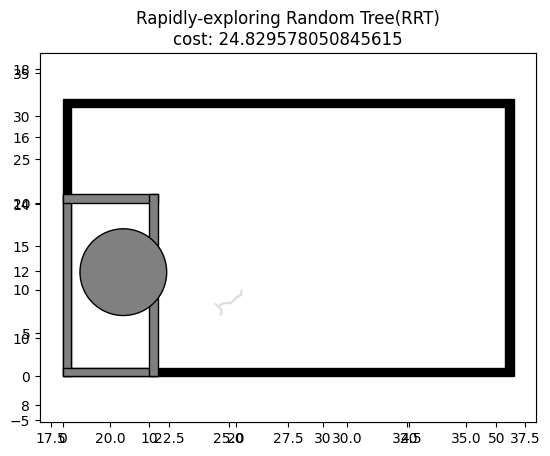

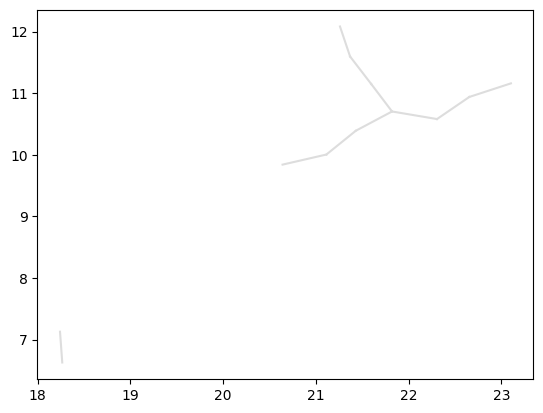

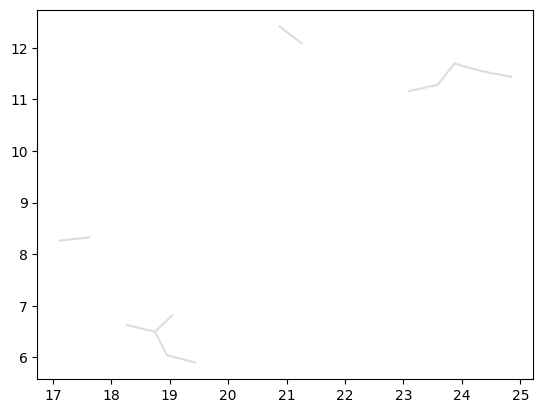

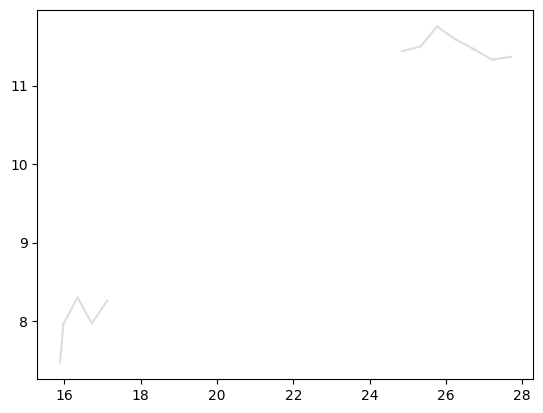

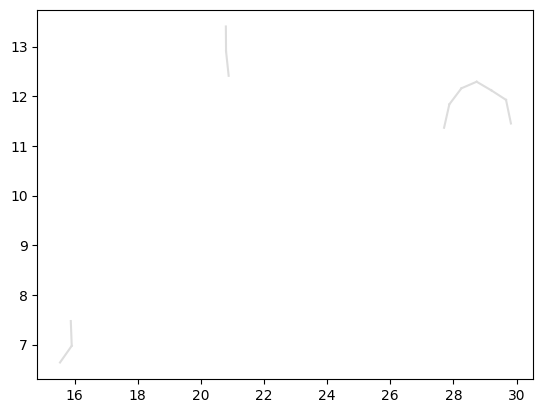

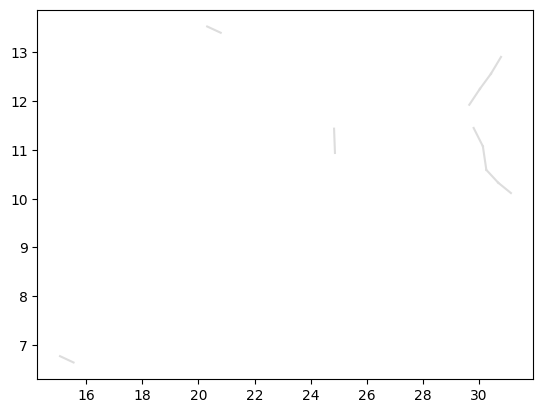

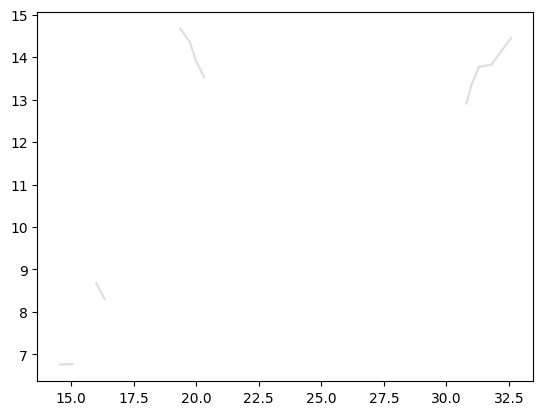

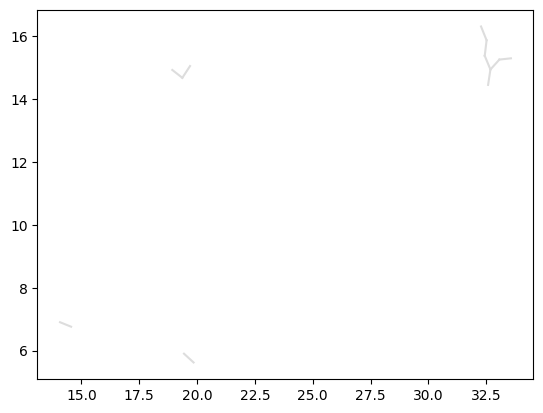

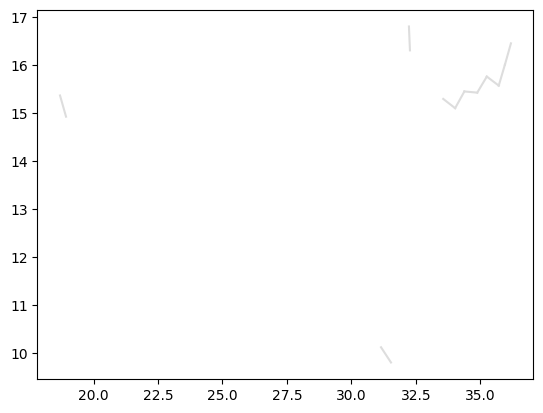

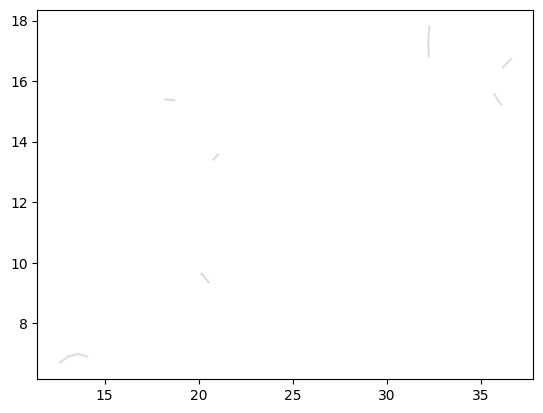

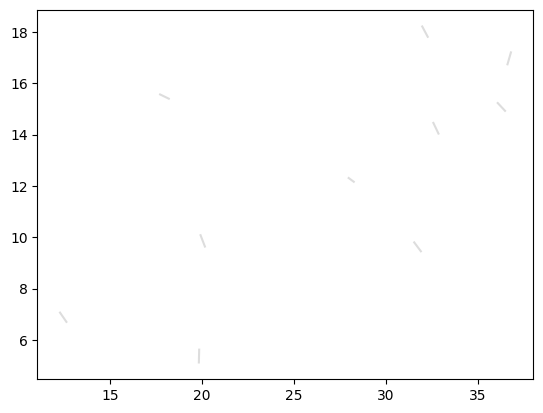

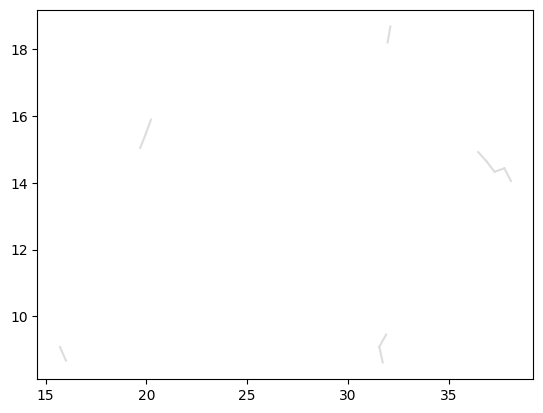

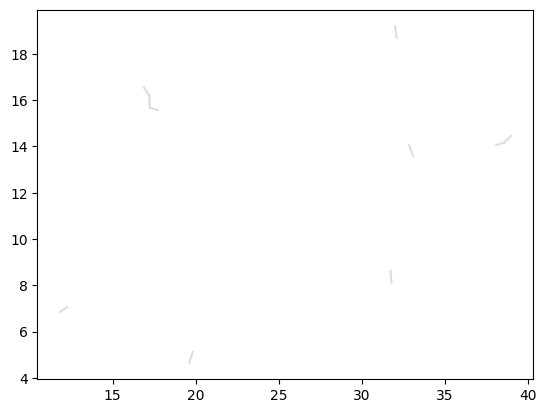

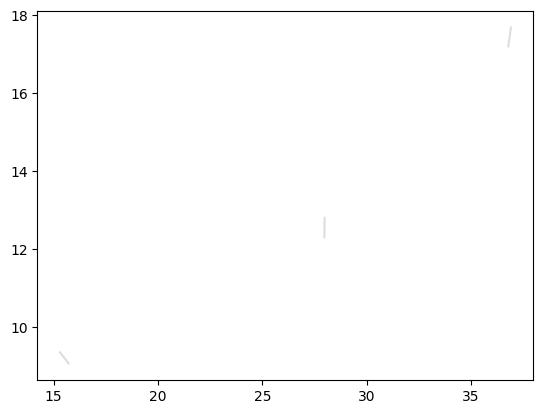

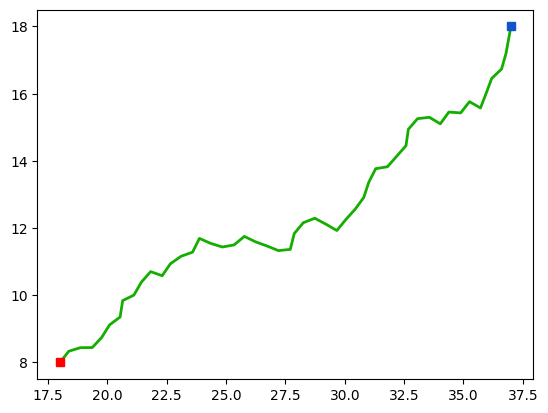

In [20]:
import python_motion_planning as pmp

# Create environment with custom obstacles
env = pmp.Map(51, 31)

# obs_rect = None
x=10
y=20

obs_rect = [
    [0, 0, 1, y+1],
    [0, y, x+1, 1],
    [0, 0, x+1, 1],
    [x, 0, 1, y+1]
    # [1, 0, 8, 2],
    # [18, 22, 8, 3],
    # [26, 7, 2, 12],
    # [32, 14, 10, 2]
]

obs_circ = [
    [7, 12, 5],
    # [46, 20, 2],
    # [15, 5, 2],
    # [37, 7, 3],
    # [37, 23, 3]
]
env.update(obs_rect=obs_rect, obs_circ=obs_circ)

planner = pmp.RRT(start=(18, 8), goal=(37, 18), env=env)    # create planner
cost, path, expand = planner.plan()                         # plan
planner.plot.animation(path, str(planner), cost, expand)  